
Kamal Udin & Ramsey Villarreal<br/>
CSC 576 - Data Mining<br/>
Dr. Burns<br/>

In this notebook, we will classify wether a star has an exoplanet orbiting it or not. The dataset can be found at https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data. The original data was downloaded from the Mikilski Archive. The data is from the kepler telescope. The data is from Kepler's Campain-3 since it is not likely to contain any undiscovered exoplanet-stars. More data can be found here http://archive.stsci.edu/k2/data_search/search.php, it is worth noting that the Kaggle dataset already contains all of the stars with exoplanets in it. 

The main goal of the Kepler telescope was to discover Earth-size planets orbiting stars in our galaxy. This was achieved by launching the telescope into orbit and obseving 100 square degrees of the sky for about 80 days at a time, with the exposure of each picture being around 6 seconds. A transit event is "when a planet passes in front of a star as viewed from Earth"(https://www.nasa.gov/mission_pages/kepler/overview/index.html). As a transit even occurs, there will be a dip in the brightness of the star. After an exoplanet is detected orbiting a star it is then easy to calculate the obit size, mass of the star, size of the planet, and characteristic temperature of the planet. The field of view of Kepler is between the Cygnus and Lyra constellations. The Kepler campaign lasted from 2009-2013, with the second mission, K2, starting in 2014. 

The flux values in the datasets are the PDC_Sap flux values (Pre-search Data Conditioning Simple Aperture Photometry). 

From Nasa's webiste - https://keplerscience.arc.nasa.gov/PyKEprimerLCs.shtml, this is how the data is calculated:

"Systematic artifacts are characterized by quantifying the features most common to hundreds of strategically-selected quiet targets on each detector channel. For each channel and each operational quarter, this characterization is stored as 16 best-fit vectors called “Cotrending Basis Vectors” (CBVs). The basis vectors archived represent the most common trends found over each channel. The CBVs are ranked by order of the relative amplitude they contribute to systematic trends across a channel."

This supposedly creates an "improvement in the quality of artifact mitigated photometry." Basically removing unwanted noise from the data. 

Additional light curves can also be found at the Mikilski Archive.  It is not clear which light curve was used in the Kaggle dataset. This could be problematic as certain light curves may make it easier to detect whether there is an exoplanet or not. A big deciding factor in this is if exoplanets tend to form around certain types of stars. Different types of stars burn at different temperatures and therefore give off different amount of electomagnetic waves at different parts of the spectrum. This could be worth looking into more in depth. 


Out of the 5000 or so observations that were gathered, only 42 of them have exoplanets. This is split up to have 37 in the training set and 5 in the test set. The observations with exoplanets should see a dip in their flux values that will last about a couple of days when a transit event occurs. There may only be one of these events in the observations or a couple, depending on how many exoplanets are orbiting the star and how many were observed while Kepler was focused on that area of space. Unfortunately we do not know when this event occured, for how long it occured, or how many times there was a transit. We had thought about splitting up some of the data to reduce the dimesionality and create more artificial observations with exoplanets, but this may be unwise as it could create inconsistent data and observations that are labeled as having an exoplanet but do not have a transit event. 

Flux is defined as the amount of energy reaching each square centimeter of a detector. The flux of a star is typically denoted by:

$$flux = \frac{luminosity}{(4pi*distance^2)}$$

This would always give an answer tht is positive, but some of the observations  do contain negative numbers. Upon further research, many dectotors use flux density which is defined as the amount of energy per unity area per unit wavelength. It is denoted as:

$$1 Jy = 10^{-26} \frac{W}{m^2*Hz} = 10^{-23} \frac{erg}{s*cm^2*Hz}$$

That is equal to 1 Janksy. Most sources use micro or milli-janskies as janskies are too large. 
The "instrumental magnitude" uses a logarithmic scale to measure light. The Hipparchus scale is:

$$m_i = C - 2.5\log_{10}{f_i} \quad where \ f_i = source \ flux \ density$$

On this scale the sun is less than -25, Sirius (the brightest star in the sky) is -1, and the faintest star the naked eye can see is about 6. Although it was not explitely stated in the documentation (as far as we could tell) the telescope seems to be using a magnitude scale in micro-janskies. This would explain some of the flux values being negative.  



# Importing the packages

We import the following packages:

    numpy : This is a package generally used to store and process arrays. 
    pandas : This is a package generally meant to store import and store dataframes in Pandas format. Pandas provides the functionalities for alterations/processing in the dataset. (Shortened name as 'pd')
    matplotlib.pyplot : This package is imported (shortened as 'plt') is used to create any plots
    statistics : This package is generally used to calculate some statistics like mean, median etc.
    scipy : This package is a scientific and mathematical package. We will use this in this project
    os : This is a package which is generally used to change current working directory, create directory and directory and file related operations
    sklearn: This package contains many useful packages from classifiers to methods that help with preprocessing data.
    tensorflow: Tensorflow is a powerful machine learning package, in this notebook we will use it to create a Long Short Term Memory neural network. 
   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from scipy import stats
import os
from sklearn import preprocessing
import tensorflow as tf

# We will change the directory to the directory where the datasets are stored using the 
#os.chdir("/Users/adarak/Downloads/Decision Tree, Naive Bayes, Regression/kepler-labelled-time-series-data")


Let's set the numpy and tensorflow for reproducibility

In [63]:
np.random.seed(42)
tf.random.set_random_seed(42)

# Importing the datasets - Training and Testing

Why do we need to import the datasets?

    The data we currently have after importing is in csv format. we need to get that into python and do processing like model building or any kind of analysis. For that the datasets needs to be in a format that the python understands. So, Pandas is a package that will help to convert the csv data into dataframe that python understands . We will import as shown below: 
    
    
We will use the kaggle api if the dataset is not already locally downloaded onto you machine. More information about setup and how to use it can be found here - https://github.com/Kaggle/kaggle-api.

Make sure that your kaggle credentials are in '~/.kaggle/kaggle.json'. They can be downloaded by going to Kaggle account and selecting 'Create API Token'

In [2]:
import kaggle 

kaggle.api.authenticate() # Use kaggle.json to authenticate
!kaggle datasets download -d keplersmachines/kepler-labelled-time-series-data # download the dataset

 99%|█████████████████████████████████████▋| 57.0M/57.4M [00:07<00:00, 12.2MB/s]
100%|██████████████████████████████████████| 57.4M/57.4M [00:07<00:00, 7.85MB/s]


In [3]:
!unzip kepler-labelled-time-series-data #unzip the dataset 

Archive:  kepler-labelled-time-series-data.zip
  inflating: exoTest.csv             
  inflating: exoTrain.csv            


In [64]:
# Please note that this csv files has to be in the same location as the path you gave in os.chdir() 
#in the above cells
test = pd.read_csv("exoTest.csv")
test 
train=pd.read_csv("exoTrain.csv")
train

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,2,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,2,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,2,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,2,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


Generally to apply machine learning model, the dependant variable has values 0s and 1s. But here it is 1 and 2. Generally class 0s should have more observations and 1s should have less observations. So, 1 in our dataset are more, so lets label them as 0s and 2 as 1s


Hence, we would like to relabel the "LABEL" column. So, we change the values of '1' of "LABEL" to 0 and '2' to 1

We are doing this using the functionaly in numpy package as shown below

so, np.where is a function of numpy which is used to do this. np.where takes in three parameters

first parameter is the logical condition, second parameter is the value it wants to replace wherever the condition is met, and thrid parameter is the value it wants to replace wherever the condition is not met. So according to the below code, the codition is "Y==1" and if Y is '1' then it will relabelled as 0, if Y is not '1' then it will be relabelled as 1

In [65]:
test["LABEL"]=np.where(test["LABEL"]==1,0,1)
train["LABEL"]=np.where(train["LABEL"]==1,0,1)

After the above step the training dataset is stored in "train" variable and testing dataset is stored in test variable. Meaning - train is a pandas dataframe of training dataset and test is a pandas dataframe of testing dataset

Lets look at top 5 rows in the imported datasets by using head() function as shown below. We do this to see whether the data has imported properly or not

In [66]:
train.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [67]:
test.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,1,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,1,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,1,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,1,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


    Lets check the shape of the train dataset, i.e. we check the number of rows and number of columns in training dataset as shown below: train.shape will give us (row,column) 

In [68]:
train.shape

(5087, 3198)

So, from the above results, we see that training dataset has 5087 rows and 3198 columns

    Lets look into the columns list now by running train.columns

In [69]:
train.columns

Index(['LABEL', 'FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6',
       'FLUX.7', 'FLUX.8', 'FLUX.9',
       ...
       'FLUX.3188', 'FLUX.3189', 'FLUX.3190', 'FLUX.3191', 'FLUX.3192',
       'FLUX.3193', 'FLUX.3194', 'FLUX.3195', 'FLUX.3196', 'FLUX.3197'],
      dtype='object', length=3198)

Lets do the same for test and check

In [70]:
test.shape

(570, 3198)

In [71]:
train.columns

Index(['LABEL', 'FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6',
       'FLUX.7', 'FLUX.8', 'FLUX.9',
       ...
       'FLUX.3188', 'FLUX.3189', 'FLUX.3190', 'FLUX.3191', 'FLUX.3192',
       'FLUX.3193', 'FLUX.3194', 'FLUX.3195', 'FLUX.3196', 'FLUX.3197'],
      dtype='object', length=3198)

The test dataset also has got 3198 columns and 570 rows

We can see that the list has "LABEL" column and FLUX.1 through FLUX.3197. which means, we have 3197 independent variables which will be used as predictor variables and LABEL is the variable which needs to be predicted, we generally call this as "dependant variabel" as this is dependent on the 3197 independent variables


 Lets look at what LABEL column has got in it. We do value_counts() of this variable to check what are the values that LABEL column has got in it and for how many observations that these values are there

In [72]:
print('-------------')
print(train['LABEL'].value_counts())
print('-------------')

-------------
0    5050
1      37
Name: LABEL, dtype: int64
-------------


We see that there are 37 observations with LABEL = '2' and 5050 observations with LABEL = '1'

We will this for check for test dataset as well

In [73]:
print('-------------')
print(test['LABEL'].value_counts())
print('-------------')

-------------
0    565
1      5
Name: LABEL, dtype: int64
-------------


We see that there are 5 observations with LABEL = '2' and 565 observations with LABEL = '1'

Now lets store the list of independent columns i.e. FLUX.1 through FLUX.3197 in a list called as X_col. So, X_col is a list from FLUX.1 through FLUX.3197

In [74]:
X_col=[col for col in train.columns if col != "LABEL"]
print(X_col)

['FLUX.1', 'FLUX.2', 'FLUX.3', 'FLUX.4', 'FLUX.5', 'FLUX.6', 'FLUX.7', 'FLUX.8', 'FLUX.9', 'FLUX.10', 'FLUX.11', 'FLUX.12', 'FLUX.13', 'FLUX.14', 'FLUX.15', 'FLUX.16', 'FLUX.17', 'FLUX.18', 'FLUX.19', 'FLUX.20', 'FLUX.21', 'FLUX.22', 'FLUX.23', 'FLUX.24', 'FLUX.25', 'FLUX.26', 'FLUX.27', 'FLUX.28', 'FLUX.29', 'FLUX.30', 'FLUX.31', 'FLUX.32', 'FLUX.33', 'FLUX.34', 'FLUX.35', 'FLUX.36', 'FLUX.37', 'FLUX.38', 'FLUX.39', 'FLUX.40', 'FLUX.41', 'FLUX.42', 'FLUX.43', 'FLUX.44', 'FLUX.45', 'FLUX.46', 'FLUX.47', 'FLUX.48', 'FLUX.49', 'FLUX.50', 'FLUX.51', 'FLUX.52', 'FLUX.53', 'FLUX.54', 'FLUX.55', 'FLUX.56', 'FLUX.57', 'FLUX.58', 'FLUX.59', 'FLUX.60', 'FLUX.61', 'FLUX.62', 'FLUX.63', 'FLUX.64', 'FLUX.65', 'FLUX.66', 'FLUX.67', 'FLUX.68', 'FLUX.69', 'FLUX.70', 'FLUX.71', 'FLUX.72', 'FLUX.73', 'FLUX.74', 'FLUX.75', 'FLUX.76', 'FLUX.77', 'FLUX.78', 'FLUX.79', 'FLUX.80', 'FLUX.81', 'FLUX.82', 'FLUX.83', 'FLUX.84', 'FLUX.85', 'FLUX.86', 'FLUX.87', 'FLUX.88', 'FLUX.89', 'FLUX.90', 'FLUX.91', 'FLUX.9

We have already seen that the 'train' and 'test' are pandas dataframe. But we want to seperate out independent variables(X) and dependent variables(Y) from train dataframe as X and Y and test dataframe as X_test and Y_test

So, X will only have the X_col list, we do this as shown below and we also check the top 5 rows of X by using head() function

In [75]:
X=train[X_col]
Y=train["LABEL"]

X.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


We do the same for test dataset as well

In [76]:
X_test=test[X_col]
Y_test=test["LABEL"]

X_test.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,...,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43,57.72
1,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,...,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86,-2034.72
2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,...,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79,30.63
3,-826.00,-827.31,-846.12,-836.03,-745.50,-784.69,-791.22,-746.50,-709.53,-679.56,...,122.34,93.03,93.03,68.81,9.81,20.75,20.25,-120.81,-257.56,-215.41
4,-39.57,-15.88,-9.16,-6.37,-16.13,-24.05,-0.90,-45.20,-5.04,14.62,...,-37.87,-61.85,-27.15,-21.18,-33.76,-85.34,-81.46,-61.98,-69.34,-17.84


# Summary statistics of training dataset: 

    We run the summary statistics using 'describe()' function. So we will get mean, standard deviation, min, 25%,50%,75% and maximum for every variable

In [77]:
train.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,0.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,0.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,0.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,0.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,0.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,1.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


In [78]:
label = train["LABEL"]
label.head()

0    1
1    1
2    1
3    1
4    1
Name: LABEL, dtype: int64

In [79]:
flux = train.drop('LABEL',1)
flux.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [80]:
confirmedExos = train.loc[train['LABEL'] == 1]
confirmedExos.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,37.0,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,...,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000
mean,1.0,4096.965405,3524.308108,2771.165405,2223.029189,1836.404324,1283.214595,1129.359730,486.174865,46.912703,...,-256.074595,-649.084595,-925.024054,-851.480000,-614.981622,-311.163514,69.504324,335.871081,721.738378,1011.166486
std,0.0,24781.136932,21305.507167,16806.475389,13533.909607,11181.958157,7923.521630,7055.157534,3178.094634,767.865143,...,2056.312131,3912.855401,5574.043660,5300.049667,3918.965417,2326.334209,917.192053,1810.879809,3928.618635,5587.380463
min,1.0,-1831.310000,-1781.440000,-1930.840000,-2016.720000,-1963.310000,-1956.120000,-2128.240000,-2188.200000,-2212.820000,...,-11143.450000,-23351.450000,-33590.270000,-31861.950000,-23298.890000,-13056.110000,-3393.580000,-3407.780000,-3391.560000,-3397.030000
25%,1.0,-66.470000,-76.330000,-76.230000,-72.250000,-79.310000,-115.640000,-135.180000,-96.270000,-83.970000,...,-71.690000,-35.720000,-32.210000,-29.210000,-33.150000,-14.980000,-11.800000,-24.730000,-44.550000,-16.800000
50%,1.0,31.290000,46.370000,33.300000,16.630000,17.010000,-3.760000,-4.090000,5.320000,1.480000,...,6.450000,-3.730000,-3.730000,4.560000,-0.040000,4.790000,7.380000,6.460000,1.630000,9.210000
75%,1.0,207.370000,163.570000,150.450000,135.340000,104.900000,100.430000,103.950000,66.200000,77.800000,...,50.050000,30.340000,28.500000,50.120000,28.800000,56.430000,39.320000,37.320000,40.400000,71.590000
max,1.0,150725.800000,129578.360000,102184.980000,82253.980000,67934.170000,48063.520000,42745.020000,18971.550000,2983.580000,...,3671.030000,2249.280000,2249.280000,2437.780000,2584.220000,3162.530000,3398.280000,9444.520000,23261.020000,33565.480000


The next block looks at a random sampling of the time series of both observations labeled as having an exoplanet and not having an exoplanet. 

It is difficult to tell exactly where the transits happen in the observations, therefore it may not be possible to reduce dimensionality or we might cut out the transit completely. 

I was also expecting to see sin like qualities in the observations with exoplanets. This could be the case if there were multiple transits that happened throughout the data, but this would be unlikely with an observation period of only 80 days. The planet would have to be extremely close to the star to see multiple transits. There is a planet around the star 55 Cancri that has an orbit time of about 18 hours. To put this into perspective, Mercury (the closest planet to the sun) has an orbital period of about 88 days. The planet around 55 Cancri would have surface temperatures of at least a couple of thousands of degrees. 


It is not clear if the data that is labeled as having an exoplanet only includes planets that are in the habitable zone or not. If it is inclucing planets not in the habitable zone, then one would be able to see a regular, uniform dip in the flux values for a planet that is extremely close to the star. 

Some of the observations that do not contain exoplanets, are sinusoidal. This could be caused if the observations labeled as having an exoplanet only include planets within the habitable zone of that star, but there could be many other different explanations for this too. One explanation would be that some stars regualarly contract and expand. When they contract, they get hotter and produce more light - and a higher flux value. Eventually the pressure gets to be to great and the star will start expanding, cooling the star and producing a lower flux value. They will keep doing this, thus producing sinusoidal flux values. A similar event happens when the star is orbiting another star or even black hole. Theses event make the size and temperature of the star fluctuate. There are also many other astronomical events that occur that change stars temperatures, sometimes on a regular basis. 

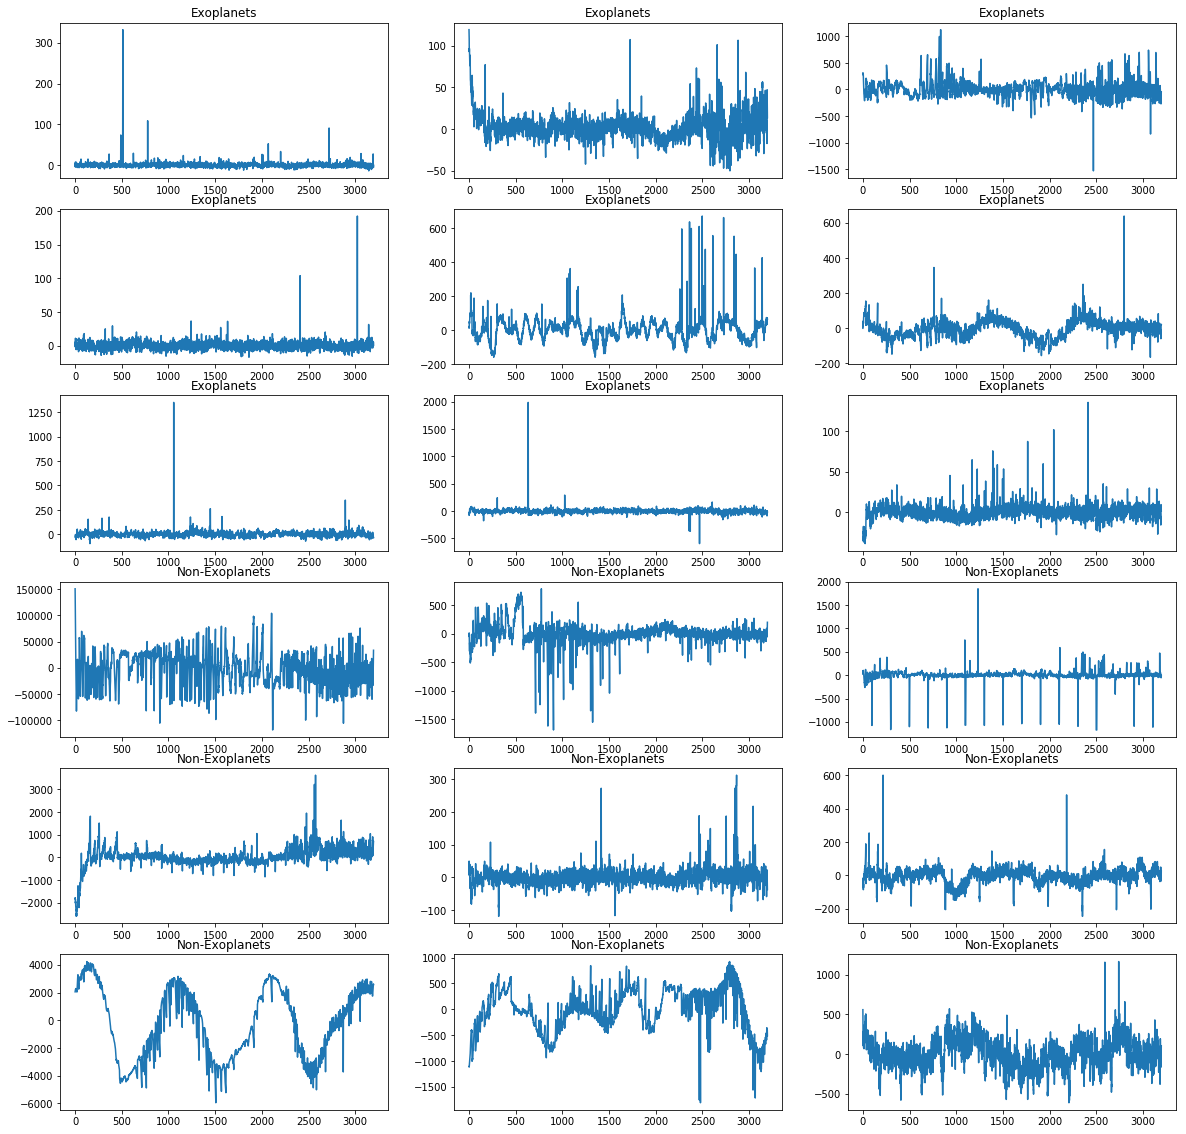

In [81]:
f, ax = plt.subplots(6,3, figsize=(20,20))

df1 = train.loc[train['LABEL'] == 0].sample(9)
df2 = confirmedExos.sample(9)

frames = [df1, df2]
result = pd.concat(frames)

counter = 0
for i in range(6):
    for x in range(3):
        flx = result.drop('LABEL',1)
        lbl = result['LABEL']
        values = flx.iloc[counter].tolist()
        lbls = [i for i in range(len(values))]
        ax[i,x].plot(lbls, values)
        if(i<3):
            ax[i,x].set_title("Exoplanets")
        else:
            ax[i,x].set_title("Non-Exoplanets")
        counter+=1
        
plt.show()

Here we show the imbalance of observations. There are over 5000 observations without exoplanets and only 37 in the training set that have exoplanets. 

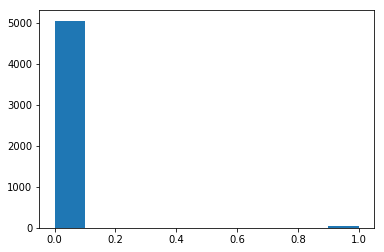

In [82]:
plt.hist(Y)
plt.show()

The next two blocks explores the minimum and maximum flux values contained in the data, along with the standard devations of the observations. 

In [83]:

stds =[]
maxes = []
mins = []

exoStds = []
exoMaxes = []
exoMins = []

noExo =[] 
Exo = []

for i,x in train.iterrows():
        if(x[0]==0):
            noExo.append(x[1:])
            stds.append(x[1:].std())
            maxes.append(max(x[1:]))
            mins.append(min(x[1:]))
        elif(x[0]==1):
            Exo.append(x[1:])
            exoStds.append(x[1:].std())
            exoMaxes.append(max(x[1:]))
            exoMins.append(min(x[1:]))
    
print("Standard Deviations: ", statistics.mean(stds), "\nMaxes: ", statistics.mean(maxes), "\nMins: ", statistics.mean(mins))
print("Standard Deviations: ", statistics.mean(exoStds), "\nMaxes: ", statistics.mean(exoMaxes), "\nMins: ", statistics.mean(exoMins))
print(stats.describe(stds))


Standard Deviations:  1267.31859798104 
Maxes:  5291.5258732673265 
Mins:  -3393.8382198019804
Standard Deviations:  1113.5995454844299 
Maxes:  5161.361621621621 
Mins:  -4347.37027027027
DescribeResult(nobs=5050, minmax=(1.7049357495544921, 1053407.4740101777), mean=1267.31859798104, variance=449543237.3160262, skewness=33.67547748684961, kurtosis=1392.562476544343)


Standard Deviations:  DescribeResult(nobs=5050, minmax=(1.7049357495544921, 1053407.4740101777), mean=1267.31859798104, variance=449543237.3160262, skewness=33.67547748684961, kurtosis=1392.562476544343) 
Maxes:  DescribeResult(nobs=5050, minmax=(11.55, 4299288.0), mean=5291.5258732673265, variance=7498046205.237072, skewness=34.50701364618662, kurtosis=1440.7487885728508) 
Mins:  DescribeResult(nobs=5050, minmax=(-2385019.12, -5.54), mean=-3393.8382198019804, variance=2262189480.379577, skewness=-33.1068692969788, kurtosis=1396.0898963735883)
Standard Deviations Exoplanets:  DescribeResult(nobs=37, minmax=(18.700217773799057, 29998.75464308205), mean=1113.5995454844299, variance=24086795.221783787, skewness=5.734752287863265, kurtosis=31.257734253016686) 
Maxes Exoplanets:  DescribeResult(nobs=37, minmax=(171.28, 150725.8), mean=5161.3616216216205, variance=606241738.0403471, skewness=5.813563388713064, kurtosis=31.876973236365288) 
Mins Exoplanets:  DescribeResult(nobs=37, minmax=(-1

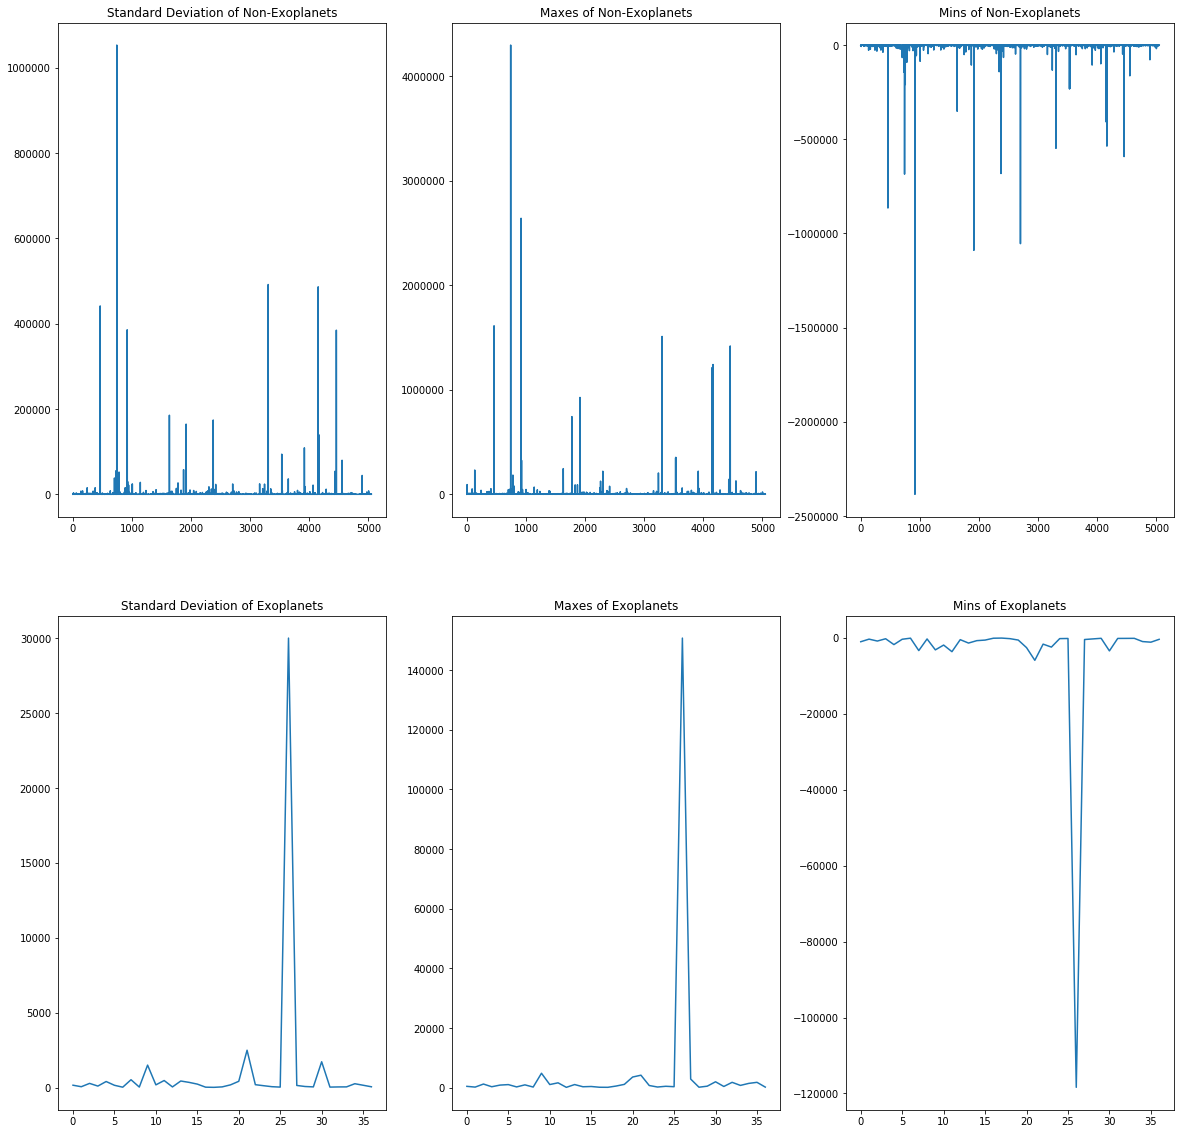

In [84]:
print("Standard Deviations: ", stats.describe(stds), "\nMaxes: ", stats.describe(maxes), "\nMins: ", stats.describe(mins))
print("Standard Deviations Exoplanets: ", stats.describe(exoStds), "\nMaxes Exoplanets: ", stats.describe(exoMaxes), "\nMins Exoplanets: ", stats.describe(exoMins))
print(stats.describe(stds))

f, ax = plt.subplots(2,3, figsize=(20,20))
ax[0,0].plot(stds ), ax[0,0].set_title("Standard Deviation of Non-Exoplanets")
ax[0,1].plot(maxes), ax[0,1].set_title("Maxes of Non-Exoplanets")
ax[0,2].plot(mins), ax[0,2].set_title("Mins of Non-Exoplanets")
ax[1,0].plot(exoStds), ax[1,0].set_title("Standard Deviation of Exoplanets")
ax[1,1].plot(exoMaxes), ax[1,1].set_title("Maxes of Exoplanets")
ax[1,2].plot(exoMins), ax[1,2].set_title("Mins of Exoplanets")

plt.show()

Let's delete some of the variables that we will no longer be using and free up some memory space.

In [85]:
del(stds)
del(maxes)
del(mins) 

del(exoStds)
del(exoMaxes)
del(exoMins) 

del(noExo)
del(Exo)

# Preprocessing the Data

The following functions allow us to preprocess the data in different ways. They may or may not be used during classification.


noramlizeEachRow() takes a pandas dataframe as input, without the 'LABEL' column. It then goes through each row and normalizes each row based on the min and max of that row. It returns a numpy array of the training data. 

In [25]:
def normalizeEachRow(X):

    newX = []

    for i, x in X.iterrows():

        x = x.values
        xMin = min(x)
        xMax = max(x)
        normalized = []

        for value in x:
            value = (value - xMin)/(xMax-xMin)
            normalized.append(value)

        newX.append(normalized)
    return np.asarray(newX)

StandardizeEachRow() is very similar to functionality of normalizeEachRow(), except that it standardizes the row instead of noramlizing it. 

In [26]:

def StandardizeEachRow(X):
    scaler = preprocessing.StandardScaler()

    newX = []

    for i, x in X.iterrows():

        x = x.values
        x = x.reshape(-1,1)
        scaled = scaler.fit_transform(x)
        scaled = scaled.flatten()
        newX.append(scaled)

    return np.asarray(newX)

getEqualLabels() take x as an input, where x is a pandas dataframe of the training data (including the 'LABEL' column); it then returns a dataframe with all of the observations with exoplanets, which are labeled as 1, and an equal amount observations that do not contain exoplanets, which are labeled as 0. 

In [27]:
# returns dataframe with equal amount of labels
# takes in dataframe with labels column and labels corrected to 0 and 1
# also accepts mult, where it will multiply the amount of observations without exoplanets, in case more observations
# are wanted
def getEqualLabels(x, mult=1):
    exos = x.loc[x['LABEL'] == 1]
    nonExos = x.loc[x['LABEL'] == 0]
    if(len(nonExos) > len(exos)*mult):
        nonExos = nonExos.sample(len(exos) * mult)
    frames = [exos, nonExos]
    return pd.concat(frames)

normalizeByPercentile() takes x, lower and upper as inputs. x is a pandas dataframe without the 'LABEL' column. Lower and upper are the percentile bounds in which the data will be normalized with. These are calculated over the entire dataset using numpy's percentile function. If the value of the data is lower than the lower bound, then the value will be set as the lower bound. If the data is higher than the upper bound than the value will be set to the upper bound. The function will return the data as a numpy array. 

In [28]:
# returns a numpy array that is normalized by the upper and lower constraints
# The upper and lower parameters must be a percentile between 0-100 
# The x input is a pandas DataFrame that does not contain the labels
def normalizeByPercentile(x, lower, upper):
    x = x.values
    upper = np.percentile(x,upper)
    lower = np.percentile(x,lower)
    print("Upper: ", upper, " Lower: ", lower)
    newX = []
    for i, rows in enumerate(x):
        newRow = []
        for j, value in enumerate(rows):
            if(value > upper):
                v = upper
            elif(value < lower):
                v = lower
            else:
                v = value
            newRow.append((v - lower)/(upper-lower))
            
        newX.append(newRow)
    return np.asarray(newX)

categorizeData() turns all of the values in the dataset into categorical data. It takes x as an input, where x is a pandas dataframe without the 'LABEL' column. It then itterates over all of the values in the dataset. It categorizes the data into 3 categories - 0,1,2. It will be 0 if the value before the current value that it is on is equal to it. It will be 1 if the value before the current value is greater than the current value. It will be 2 if the current value is greater than the value before the current one. This will end up returning a numpy array, but it will have one less column then the input dataset. 

In [29]:
def categorizeData(x):
    x = x.values
    newX = []
    
    for i, row in enumerate(x):
        newRow = []
        for j, value in enumerate(row[1:]):
            if(row[j-1] > row[j]):
                newValue = 1
            elif(row[j-1] < row[j]):
                newValue = 2
            else:
                newValue = 0
            newRow.append(newValue)
        
        newX.append(newRow)
        
    return np.asarray(newX)

batch_shuffle() is inspired by code in "Hands-On Machine Learning with Scikit-Learn & Tensorlfow" pg. 347. It takes a list of features and target values, shuffles them using indexes randomly selected by np.random.permutation() and yeilds each batch as it is needed for the batch training. Yield is used instead of return so that the rest of the training can be executed before another batch is given from the function, saving on initial loading time and memory space. 

In [30]:
def batch_shuffle(x_train, y_train, batch_size):
    rand_ind = np.random.permutation(batch_size)
    batches = len(x_train)//batch_size
    for batch_ind in np.array_split(rand_ind, batches):
        x_batch, y_batch = x_train[batch_ind], y_train[batch_ind]
        yield x_batch, y_batch

# 1.Naive-Bayes Model

The first line "from sklean.naive_bayes import GaussianNB" imports this package. In python, we need to import the package to be able to use its functionality. Most of the machine learning packages are with sklearn. Here we import naive_bayes package (shortened as "GaussianNB") from sklearn. This function if applied on a dataset given X and Y(where X is independent variables dataset i.e. 3197 columns in our case) and Y (relabelled colun having 0s and 1s). 

First we create an instance of GaussianNB and the fit on our dataset

In [31]:
from sklearn.naive_bayes import GaussianNB # importing the package
clf = GaussianNB(priors=[0.01,1-0.01]) # creating an instance of GaussianNB
clf.fit(X, Y) # fitting on our training dataset

GaussianNB(priors=[0.01, 0.99])

Now the 'clf' object has the set of rules in the backend using Naive Bayes algorithm that can be used to predict for any new dataset. This means that clf tried to look into training dataset(X,Y) and was able to write some rules for predicting for new dataset. The new dataset in our case will be test dataset. We do this to check, how our algorithm which was built on training works on test dataset. This means that clf object will be used to predict the "LABEL" of test dataset which will be as 0s and 1s(as that is how we input the data above). 

Lets first use clf object to predict on training dataset itself

In [32]:
pred_train=clf.predict(X) # We are applying clf rules to predict on Train dataset

Now we have the predictions of test dataset, which will be list of 0s or 1s as shown below

We will evaluate the model's accuracy i.e. how good is our model. FOr this we need to know about the concept of confusion matrix:


Confusion Matrix looks like below:
                    Predicted 1               Predicted 0
    Actual 1     True Positive(TP)          False Negative(FN)
    Actual 0     False Positive(FP)         True Negative(TN)
    
TP is number of Actual class=1 and predicted class=1
FN is number of Actual class=1 and predicted class=0
FP is number of Actual class=0 and predicted class=1
TN is number of Actual class=0 and predicted class=0

For the formulas please refer to this link: https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

In [33]:
from sklearn import metrics
print(metrics.classification_report(Y,pred_train))

             precision    recall  f1-score   support

          0       0.99      0.02      0.05      5050
          1       0.01      0.97      0.01        37

avg / total       0.98      0.03      0.05      5087



In [34]:
print(metrics.confusion_matrix(Y,pred_train))

[[ 125 4925]
 [   1   36]]


We will do the same for test dataset as well

In [35]:
pred_test=clf.predict(X_test) 

In [36]:
from sklearn import metrics
print(metrics.classification_report(Y_test,pred_test))

             precision    recall  f1-score   support

          0       1.00      0.02      0.03       565
          1       0.01      1.00      0.02         5

avg / total       0.99      0.02      0.03       570



In [37]:
print(metrics.confusion_matrix(Y_test,pred_test))

[[  9 556]
 [  0   5]]


In [38]:
np.sum(pred_test==0)

9

Conclusion: Naive Bayes model is very bad at predicting the LABEL = '2' because for the test dataset none of the LABEL='2' got predicted properly. However for the training dataset, out of 37 LABEL = '2' observations, 27 are predicted properly and remaining 10 are predicted as LABEL='1'. Hence it is performing bad. Lets see if we get some good results from Decision Tree

This is a dataset where Label1(i.e. value 0) above occurs very frequently, while Label2(i.e. value 1) occurs very rarely
 
The Naive Bayes model performs very poorly. In the out-of-sample test set which avoids datamining, the f1-score us only 0.03 which is far worse than guessing. It predicts Label 1 (i.e. value 0) only 9 times when there are 565 correct answers, and predicts Label 2 most of the time. This results is the majority of the predictions on Label 2 as false positives.


Let's now do some preprocessing on the data to see if we can achieve better results with Naive Bayes.

In [39]:
categorized = categorizeData(X)
clf = GaussianNB(priors=[0.01,1-0.01]) # creating an instance of GaussianNB
clf.fit(categorized, Y) # fitting on our training dataset
pred_train = clf.predict(categorized)
print(metrics.classification_report(Y,pred_train))
print(metrics.confusion_matrix(Y,pred_train))

pred_test=clf.predict(categorizeData(X_test)) # We are applying clf rules to predict on Train dataset
print(metrics.classification_report(Y_test,pred_test))
print(metrics.confusion_matrix(Y_test,pred_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5050
          1       1.00      1.00      1.00        37

avg / total       1.00      1.00      1.00      5087

[[5050    0]
 [   0   37]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       565
          1       1.00      0.60      0.75         5

avg / total       1.00      1.00      1.00       570

[[565   0]
 [  2   3]]


Wow! categorizing the data before making a Naive Bayes model gives us some pretty great results.
On the training set, the model predicted everything perfectly, and on the testing set only 2 out of the 570 observations were misclassified. The two misslcassified were false negatives - predicting that there was no exoplanet on observations that did in fact have exoplanets.

# 2.Decision Tree Model

Same as Naive Bayes, lets import sklearn decision tree classifier, create an instance and use to fit for trianing dataset

In [40]:
import sklearn.tree

dt_instance = sklearn.tree.DecisionTreeClassifier()
Decision_tree = dt_instance.fit(X, Y)   
Decision_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Lets try to visualize the decision tree plotted. The above lines of code are used to create decision tree visualization. For better understanding of the entire process, please refer to: https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

In [41]:
import graphviz

In [42]:
dot_data = sklearn.tree.export_graphviz(Decision_tree, out_file=None,
                         feature_names=X_col,  
                         class_names=["1","2"],  
                         filled=True, rounded=True,  
                         special_characters=True)

In [43]:
graph = graphviz.Source(dot_data)  
graph

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

Lets use Decision Tree to predict for training and testing dataset and report their confusion matrices

In [44]:
pred_dt_train=Decision_tree.predict(X)

In [45]:
from sklearn import metrics
print(metrics.classification_report(Y,pred_dt_train))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5050
          1       1.00      1.00      1.00        37

avg / total       1.00      1.00      1.00      5087



In [46]:
print(metrics.confusion_matrix(Y,pred_dt_train))

[[5050    0]
 [   0   37]]


In [47]:
pred_dt_test=Decision_tree.predict(X_test)

In [48]:
from sklearn import metrics
print(metrics.classification_report(Y_test,pred_dt_test))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       565
          1       0.29      0.40      0.33         5

avg / total       0.99      0.99      0.99       570



In [49]:
print(metrics.confusion_matrix(Y_test,pred_dt_test))

[[560   5]
 [  3   2]]


Conclusion: From the above confusion matrix, the decision tree was able to predict one LABEL '2' properly out of 5 LABEL '2'. It was able to properly classify LABEL '1' and '2' of training dataset with 100% accuracy from the confusion matrix of training dataset. 

Overall, out of Naive Bayes model and Decision Tree model, Decision tree model is performing better in predicting LABEL '2'

The Decision Tree model performs the best so far. It has a F1-score of 98% because it mostly refrains from predicting Label 2 which is rare. However, the out-of-sample test set shows that it got 100% of the predictions on Label 2 wrong, so we wonder if there is any incremental value versue always predicting Label 1.

# 3.Regression Model


In this part of the notebook, we will use a LogisticRegression model to try to classify the data.

We will use sklearn's implementation of LogisticRegression from teh sklearn.linear_model package.

In [69]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

model2=logreg.fit(X,Y) #fit the model to the data


In [51]:
pred_lr=model2.predict(X_test)

In [52]:
from sklearn import metrics
print(metrics.classification_report(Y_test,pred_lr))

             precision    recall  f1-score   support

          0       0.99      0.52      0.68       565
          1       0.01      0.60      0.02         5

avg / total       0.98      0.52      0.67       570



In [53]:
print(metrics.confusion_matrix(Y_test,pred_lr))

[[292 273]
 [  2   3]]


Here we can that the model did not do very well.

We will now try a couple of different preprocessing steps on the data to improve the accuracy. 

In [54]:
np.sum(Y_test==0)

565

Again, this is a dataset where Label1(i.e. value 0) above occurs very frequently, while Label2(i.e. value 1) occurs very rarely

Logistic regression predicts Label1 293 times and Label2 277 times. Therefore, it performs very poorly because there are too many false positives on Label2.

In [55]:
X.shape

(5087, 3197)

The main problem with the above models is that we have too many features..3197 features. Here, we will reduce the features to 10 with PCA and the results will be much better


In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10, svd_solver='randomized',
          whiten=True).fit(X)

X_train_pca = pca.transform(X)
X_test_pca = pca.transform(X_test)

In [57]:
model2=logreg.fit(X_train_pca,Y)

In [58]:
pred_lr=model2.predict(X_test_pca)

In [59]:
from sklearn import metrics
print(metrics.classification_report(Y_test,pred_lr))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       565
          1       0.00      0.00      0.00         5

avg / total       0.98      0.99      0.99       570



C:\Users\ramse\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The precision seems to be good, but when looking at the recall, we can see that all of the predictions were for 0. The prediction only looks good because we have a very lopsided dataset.

Let's take a look at some other preprocessing methods. 

In [60]:
scaler = preprocessing.StandardScaler()
scaled = X.copy()
scaler.fit_transform(scaled)

model2=logreg.fit(scaled,Y)
pred_lr=model2.predict(X_test)
print(metrics.classification_report(Y_test,pred_lr))

             precision    recall  f1-score   support

          0       0.99      0.52      0.68       565
          1       0.01      0.60      0.02         5

avg / total       0.98      0.52      0.67       570



In the cell above, we use StandardScaler() which standardizes the data. The results seem to get a little bit better then no preproccessing steps.

In the next cell, we take a look at how making the dataset more equal might improve the scores. We will also standardize the more equalized dataset. 

In [71]:
equalized = getEqualLabels(train, mult=3)
y_equalized = equalized['LABEL']
equalized = equalized.drop('LABEL', 1)
scaler = preprocessing.StandardScaler()
scaler.fit_transform(equalized)
X_test_scaled = X_test.copy()

logreg = LogisticRegression()

scaler.fit_transform(X_test_scaled)
model2=logreg.fit(equalized,y_equalized)
pred_lr=model2.predict(equalized)
print(metrics.classification_report(y_equalized,pred_lr))
print(metrics.confusion_matrix(y_equalized,pred_lr))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       111
          1       1.00      1.00      1.00        37

avg / total       1.00      1.00      1.00       148

[[111   0]
 [  0  37]]


In [72]:
pred_lr=model2.predict(X_test_scaled)
print(metrics.classification_report(Y_test,pred_lr))
print(metrics.confusion_matrix(Y_test_resized,pred_lr))

             precision    recall  f1-score   support

          0       0.99      0.61      0.75       565
          1       0.01      0.60      0.03         5

avg / total       0.99      0.61      0.75       570

[[342 223]
 [  2   3]]


We see that in the training set, everything is classified right, but in the testing set we see that the scores go down a lot. This is likely due to overfitting of the data on the training set.


Now we will try the same thing as above, with regards to getting a more balanced dataset, but we will also normalize the datasets. We will cut out some of the outliers, anything below the second percentile or the 98th percentile will be set as that percentile. Hopefully this will cut out some noise, while still having a nice normalized dataset. 

In [75]:
upperLimit = 98
lowerLimit = 2

equalized = getEqualLabels(train, mult=10)
y_equalized = equalized['LABEL']
equalized = equalized.drop('LABEL', 1)
normalized = normalizeByPercentile(equalized, lowerLimit,upperLimit)
model2=logreg.fit(normalized,y_equalized)

pred_lr=model2.predict(normalized)

print(metrics.classification_report(y_equalized,pred_lr))
print(metrics.confusion_matrix(y_equalized,pred_lr))

pred_lr=model2.predict(X_test)

print(metrics.classification_report(Y_test,pred_lr))

print(metrics.confusion_matrix(Y_test_resized,pred_lr))

Upper:  1297.94  Lower:  -1252.2903999999999
             precision    recall  f1-score   support

          0       0.95      1.00      0.97       370
          1       1.00      0.49      0.65        37

avg / total       0.96      0.95      0.95       407

[[370   0]
 [ 19  18]]
             precision    recall  f1-score   support

          0       0.99      0.63      0.77       565
          1       0.01      0.40      0.02         5

avg / total       0.98      0.63      0.77       570

[[357 208]
 [  3   2]]


Here we can see that the model did much better on the training set than the testing set. 


In conclusion we saw that Logistic Regression produced mediocre results at best. The models seemed to be overfitting on the training dataset and not producing very genralized models. Doing some preprocessing on the dataset did produce some better results in regards to the recall of the observations with exoplanets, but it also ended up predicting a lot more observations as having exoplanets. 

# 4. LSTM 


This section will focus on creating an LSTM to try to classify the data.  They are similar to an RNN, but with an additional gate that mitgates the vanishing gradient problem in RNN's. This is why we chose to go with an LSTM over an RNN, because of the high dimentionality of the data. 

In [ ]:
tf.reset_default_graph() # resets tensorflow graph
random_seed = 42 #random seed for tensorflow and numpy for reproducibility
tf.set_random_seed(random_seed)
np.random.seed(random_seed)

input_size = 1 #input size will be 1 (i.e. it will take one feature at a time)
time_steps = 3197 # number of time steps aka number of features per observation
num_hidden = 128 #number of hidden layers

batch_size = 20 # batch size
n_epochs = 25 # number of epochs
learning_rate = .0001 # learning rate

num_classes = 1 # number of classes is 1 - we want an output of a sigmoid function that will either be 1 or 0

# make all training sets right sizes
equalized = getEqualLabels(train)
equalized_y = equalized['LABEL']
equalized = equalized.drop('LABEL', 1)
normalizedX = normalizeByPercentile(equalized, 10,90)
normalizedX = normalizedX.reshape((len(normalizedX),-1,1))
print(len(normalizedX[0]))
Y_test_resized = Y_test.reshape((-1,num_classes))
normalized_test_x = normalizeByPercentile(X_test, 10,90)
X_test_resized = normalized_test_x.reshape((len(normalized_test_x),-1, 1))




x = tf.placeholder(tf.float32, [None, time_steps, input_size])
y = tf.placeholder(tf.float32, [None, num_classes])

# define wieghts and biases to random variables
weights = {'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))}
biases = {'out': tf.Variable(tf.random_normal([num_classes]))}


The next three cells are for the LSTM implementation in pure tensorflow

In [ ]:
# model to be used in tensorflow implementation
def model(x, weights, biases):
    
    x = tf.unstack(x, time_steps, 1)
    
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    
    return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

Let's set our prediction function, along with our loss and optimizer variables

In [ ]:
logits = model(x, weights, biases)
prediction = tf.nn.softmax(logits)



#define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss) # we want to minimize the loss.

correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1)) 
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

This cell does the actual training of the network. It trains the network in batches using the batch_shuffle() method to get the batches. It then print out the accruacy for each epoch. 

In [ ]:
# train model
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        
        for X_batch, y_batch in batch_shuffle(normalizedX, equalized_y, batch_size):
            y_batch = y_batch.reshape((-1, num_classes))
#             print(type(X_batch), type(y_batch), y_batch.shape)
            sess.run(training_op, feed_dict={x: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={x: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={x: X_test_resized, y: Y_test_resized})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)
        
sess.close()

The above results were not looking good. I am fairly new to using pure tensorflow and just wanted to make sure I was doing everyhting right, so I made the same network using keras since I have much more experience with this. 

In [62]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

input_size = 1
time_steps = 3197
num_hidden = 128

batch_size = 20
n_epochs = 25
learning_rate = .0001

num_classes = 1

upperLimit = 98
lowerLimit = 2

# make all training sets right sizes
equalized = getEqualLabels(train, mult=3)
equalized_y = equalized['LABEL']
equalized = equalized.drop('LABEL', 1)
normalizedX = normalizeByPercentile(equalized, lowerLimit,upperLimit)
normalizedX = normalizedX.reshape((len(normalizedX),-1,1))
print(len(normalizedX[0]))
Y_test_resized = Y_test.reshape((-1,num_classes))
normalized_test_x = normalizeByPercentile(X_test, lowerLimit,upperLimit)
X_test_resized = normalized_test_x.reshape((len(normalized_test_x),-1, 1))




model = Sequential()
model.add(LSTM(num_hidden, input_shape=(time_steps,1 )))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
              , metrics=['accuracy'])
print(model.summary())

Using TensorFlow backend.


Upper:  1529.59  Lower:  -1492.5379999999998
3197
Upper:  675.8721999999939  Lower:  -679.6243999999992


C:\Users\ramse\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
normalized_test_x = normalizeByPercentile(X_test, lowerLimit,upperLimit)
X_test_resized = normalized_test_x.reshape((len(normalized_test_x),-1, 1))
model.fit(normalizedX, equalized_y, validation_data=(X_test_resized, Y_test_resized), epochs=3, batch_size=3)


Upper:  675.8721999999939  Lower:  -679.6243999999992
Train on 148 samples, validate on 570 samples
Epoch 1/3
148/148 [==============================] - 259s 2s/step - loss: 0.6786 - acc: 0.7432 - val_loss: 0.4888 - val_acc: 0.9912
Epoch 2/3
148/148 [==============================] - 257s 2s/step - loss: 0.5821 - acc: 0.7500 - val_loss: 0.2284 - val_acc: 0.9912
Epoch 3/3
148/148 [==============================] - 256s 2s/step - loss: 0.5896 - acc: 0.7500 - val_loss: 0.2675 - val_acc: 0.9912


In [68]:
predictions = model.predict(X_test_resized)
for i, p in enumerate(predictions):
    if(p[0] < .5):
        predictions[i][0] = 0
    else:
        predictions[i][0] = 1
print(metrics.classification_report(Y_test_resized,predictions))
print(metrics.confusion_matrix(Y_test_resized,predictions))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       565
          1       0.00      0.00      0.00         5

avg / total       0.98      0.99      0.99       570

[[565   0]
 [  5   0]]


C:\Users\ramse\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
print(metrics.confusion_matrix(Y_test_resized,predictions))

[[565   0]
 [  5   0]]


The results look to be the same wether it was ran in tensorflow or keras. These were not the only paramaeters that were tried. There were many different that were tried, but not displayed in this notebook. I tried different batch sizes, different learning rates, different number of hidden layers, even different output functions. Nothing seemed to have any effect on the results. When the training datat was very lopsided with more observations without exoplanets, the results tended to go towards 0. The only time the resutls didn't go to only 0, the training set was half observations with exoplanets and half without exoplanets. This produced about a 50/50 split int he predictions - pretty much just a random guess at that point. I thnk the one thing that could've really helped improve the results would be to have more observations of stars with exoplanets. 

tensorflow_graph_in_jupyter is taken from "Hands-On Machine Learning with Scikit-Learn & Tensorlfow". This allows tensorflow graphs to be shown using tensorboard in jupyter notebooks. We will inlcude that file with the final project so that everything is contained in this single notebook - but that file was not written by us. 

In [67]:
from tensorflow_graph_in_jupyter import show_graph
show_graph(tf.get_default_graph())

# Conclusion


This was a very interesting problem to try to tackle. A domain expert would have been very useful in clearing up a lot of questions that we had about the data. Also it would have been very useful to have more observations that contained exoplanets. This would have helped all of the models perform better, and we might have been more eager to try some different techniques too. Overall it seems as though the best model was the Naive Bayes model after the data was categorized. The Decision tree came in a close second. The logistic regresssion came in a far third place, with the LSTM coming in dead last. The LSTM not only added extra complexity but was also very resource intensive. It took by far the longest to train and had the worst results. 